In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
import scipy.interpolate as spl
import random
from berliner import CMD
from berliner.mist import read_isochrones
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("default")

import sys
sys.path.append('../') # 添加包含functionkit.py文件的目录路径
import functionkit

In [9]:
isoc_file = '/home/shenyueyue/Projects/Cluster/data/MIST_iso_64c0cd78648d6.iso.cmd'

In [17]:
isoc=read_isochrones(isoc_file)[0]

['0.2507', '1.12639E-03', '-1.12', '0.00', '0.40']


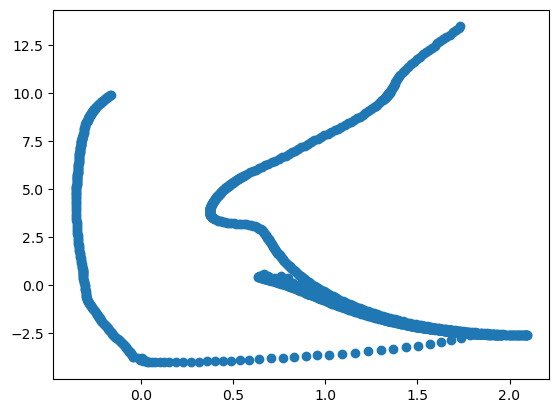

In [19]:
b = 'Bessell_B'
v = 'Bessell_V'
plt.scatter()

In [38]:
# 初始质量函数
# generate the mass catalog follow the selected IMF 
def fun_IMF(m_x,label='Kroupa'):
    '''
    Initial Mass Funcation
    label = ['Salpeter','Kroupa','Chabrier']
    '''
    while label == 'Salpeter':
        if m_x < 0.1:
            return 0
        elif m_x < 100:
            return m_x**(-2.35)
        else : 
            return 0
    
    while label == 'Kroupa':
        if m_x < 0.08 : 
            return 0
        elif m_x < 0.5 : 
            return 2*m_x**(-1.3)
        elif m_x < 150:
            return m_x**(-2.3)
        else :
            return 0
        
        
    while label == 'Chabrier':
        if m_x < 0.07 : 
            return 0
        elif m_x < 1.0 : 
            return m_x**(-1.55)
        elif m_x < 100 : 
            return m_x**(-2.7)
        else : 
            return 0

# 返回IMF的pdf       
def pdf_IMF(m_x,m_min,m_max,label='Kroupa'):
    if m_x < m_min or m_x > m_max:
        return 0
    else : 
        return fun_IMF(m_x,label)/integrate.quad(lambda x : fun_IMF(x,label), m_min, m_max)[0]

# 按照 初始质量函数 随机生成 m_n 个范围在 (m_min,m_max) 之间的质量 
def random_IMF(m_n, m_min, m_max,label='Kroupa'):
    m_result = []
    c = pdf_IMF(m_min, m_min, m_max, label)
    for i in range(m_n):
        m_flag = 0 # 标志，判断生成的 mass 是否已经到达设定的质量上限 m_max
        while m_flag == 0:
            m_x = random.uniform(m_min, m_max) # 从(m_min, m_max)的均匀分布中随机抽取一个数
            m_y = random.uniform(0,1) 
            if m_y < pdf_IMF(m_x, m_min, m_max, label)/c: 
                m_result.append(m_x)
                m_flag = 1
    return m_result

In [40]:
isoc

EEP,log10_isochrone_age_yr,initial_mass,star_mass,log_Teff,log_g,log_L,[Fe/H]_init,[Fe/H],Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,2MASS_J,2MASS_H,2MASS_Ks,Kepler_Kp,Kepler_D51,Hipparcos_Hp,Tycho_B,Tycho_V,Gaia_G_DR2Rev,Gaia_BP_DR2Rev,Gaia_RP_DR2Rev,Gaia_G_MAW,Gaia_BP_MAWb,Gaia_BP_MAWf,Gaia_RP_MAW,TESS,Gaia_G_EDR3,Gaia_BP_EDR3,Gaia_RP_EDR3,phase,_lgmass,_mhini,_lgage,_eep
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
244,10.0,0.1,0.09999914480493008,3.5302065787014376,5.3320995243170675,-2.818485010397106,-1.12,-1.078062,17.038164,15.197521,13.46558,12.33251,11.245905,10.039533,9.28267,9.055629,12.481447,14.490652,13.437222,15.743472,13.680432,12.523476,13.725343,11.485902,12.500475,13.671252,13.718161,11.465718,11.438389,12.520192,13.698544,11.467186,0.0,-1.0,-1.12,10.0,244
245,10.0,0.1017056007457137,0.10170471709299955,3.5314266351269,5.327006782948439,-2.802505279861405,-1.12,-1.078005,16.946638,15.127972,13.404666,12.278327,11.201674,10.00187,9.247764,9.021297,12.429417,14.422522,13.379655,15.668888,13.61859,12.472401,13.665051,11.439797,12.449287,13.611354,13.658319,11.419648,11.392925,12.469028,13.638247,11.421254,0.0,-0.9926551305975744,-1.12,10.0,245
246,10.0,0.10518088970714301,0.10517994403487099,3.533945722911496,5.316551982301998,-2.7697349050161852,-1.12,-1.077872,16.76144,14.986715,13.277212,12.169381,11.111302,9.924789,9.176039,8.95101,12.323461,14.284002,13.260131,15.51745,13.489523,12.368338,13.539572,11.345475,12.345002,13.486655,13.533953,11.325411,11.299929,12.364788,13.512634,11.32732,0.0,-0.9780631598843366,-1.12,10.0,246
247,10.0,0.1085384606339338,0.10853745117937794,3.5363799096348254,5.306443455851868,-2.7380649922394507,-1.12,-1.077749,16.586731,14.852525,13.157743,12.065465,11.024319,9.850518,9.106915,8.883221,12.223525,14.152258,13.148323,15.373817,13.368444,12.269017,13.421106,11.254398,12.245625,13.36935,13.416619,11.234446,11.210497,12.265437,13.39428,11.236715,0.0,-0.964416342171772,-1.12,10.0,247
248,10.0,0.11178280794360301,0.1117817330748217,3.538732380066476,5.296668272590056,-2.7074540427430946,-1.12,-1.077626,16.416145,14.721275,13.045934,11.966322,10.940825,9.779007,9.040365,8.817926,12.128135,14.024773,13.041785,15.237612,13.254879,12.175253,13.310144,11.167303,12.151654,13.259021,13.306351,11.147348,11.124308,12.171502,13.283321,11.149779,0.0,-0.9516249852631825,-1.12,10.0,248
249,10.0,0.11537917411851148,0.115378022464453,3.541339456641304,5.285823411028664,-2.6735152639219972,-1.12,-1.077483,16.232206,14.579799,12.924127,11.857871,10.849121,9.699923,8.966997,8.745897,12.023764,13.885521,12.925413,15.086496,13.131153,12.072712,13.189162,11.072788,12.048864,13.138688,13.186066,11.052818,11.030531,12.068748,13.162346,11.055412,0.0,-0.9378725740367156,-1.12,10.0,249
250,10.0,0.11887942150750336,0.11887819023151108,3.5438774414784735,5.2752549065411625,-2.6404677257341826,-1.12,-1.077326,16.059845,14.446049,12.807531,11.753651,10.761417,9.623378,8.896084,8.676359,11.923535,13.753337,12.813751,14.943358,13.01272,11.974338,13.073274,10.98205,11.950221,13.023383,13.070788,10.962155,10.94085,11.970132,13.046465,10.965002,0.0,-0.9248933169474838,-1.12,10.0,250
251,10.0,0.12231454260928258,0.12231322795146941,3.546369365453523,5.264864780971772,-2.608012177799168,-1.12,-1.077188,15.895866,14.317738,12.694625,11.652338,10.675735,9.548519,8.826813,8.608422,11.826099,13.626013,12.705357,14.806291,12.898026,11.878747,12.960963,10.893472,11.85435,12.911601,12.959018,10.87361,10.853174,11.874285,12.934163,10.876655,0.0,-0.9125219043742507,-1.12,10.0,251
252,10.0,0.1257133095609798,0.12571190733831938,3.5488345551225606,5.254570433857843,-2.575887384234988,-1.12,-1.077046,15.736641,14.192372,12.583952,11.552676,10.591208,9.474513,8.758369,8.5

In [49]:
labelIMF='Kroupa'
bands = ['Bessell_B','Bessell_V']
dist_mod = 14.4 # 距离模数, dist in unit "Mpc"
fbin=0.35 # 双星比

temiso = isoc
tem = temiso
tem = tem[(tem['phase']>=-1)&(tem['phase']<=4)] # MS ~ EAGB

logAge = tem['log10_isochrone_age_yr'][0]
MH = tem['[Fe/H]_init'][0]
#tem['Vmag_obs'] = tem['Vmag'] + dist_mod

massmin = 0.66# min(tem[]['initial_mass'])
massmax = max(tem['initial_mass'])

# 质量
mass = random_IMF(10000,massmin,massmax,label=labelIMF) # 生成初始质量 primass 
cat = pd.DataFrame(np.zeros((10000,1)),columns=['primass']) # 创建星表
cat['primass'] = mass
cat['age'] = logAge
cat['mh'] = MH

# 双星系统
secindex = random.sample(list(cat.index),k=int(len(cat)*fbin)) # 按双星比 fbin 随机抽取为双星系统的样本
cat['secmass'] = np.zeros(len(cat))
bintem = temiso[temiso['phase']==0] # MS 主序
secmass = random_IMF(int(len(cat)*fbin),min(bintem['initial_mass']),max(bintem['initial_mass']),label=labelIMF) # 生成双星中伴星的初始质量
cat['secmass'][secindex] = secmass # 双星系统中伴星的质量

In [91]:
d=7500
5*np.log10(d)-5

14.3753063169585

In [90]:
massmin

0.0936335474

In [50]:
# 流量
for band in bands:
    cat['%s_pri'%(band)] = np.zeros(len(cat))
    cat['%s_sec'%(band)] = np.zeros(len(cat))
    
    if tem['phase'][-1] <= 2: # MS,SGB,RGB, 如果等时线样本 tem 的阶段到RGB为止
        iso1 = tem
        fmass_band1 = spl.interp1d(iso1['initial_mass'],iso1['%s'%(band)]) # 拟合流量-质量关系函数
        for h in range(len(cat)):
            cat['%s_pri'%(band)][h] = fmass_band1(cat['primass'][h]) # 给 cat 表中对应的 primass 赋流量值
        # 对单星，真实流量为其本身的流量
        cat['%s_true'%(band)] = cat['%s_pri'%(band)]
        # 对双星系统
        for h in secindex: 
            cat['%s_sec'%(band)][h] = fmass_band1(cat['secmass'][h]) # 按照伴星的质量 secmass 赋伴星的流量值
            cat['%s_true'%(band)][h] = -2.5*np.log10(pow(10,-0.4*cat['%s_pri'%(band)][h])+pow(10,-0.4*cat['%s_sec'%(band)][h])) # 对双星系统，真实流量由主星和伴星共同贡献
            
    if tem['phase'][-1]>2: # CHEB, CHEB_b, CHEB_r, EAGB, 如果等时线样本 tem 存在演化到 RGB 后的阶段 
        iso1 = tem[tem['phase']<=2] # MS,SGB,RGB
        fmass_band1 = spl.interp1d(iso1['initial_mass'],iso1['%s'%(band)],fill_value='extrapolate')
               
        iso2 = tem[tem['phase']>=3] # CHEB-EAGB,core He-burning, not include TP-AGB
        fmass_band2 = spl.interp1d(iso2['initial_mass'],iso2['%s'%(band)])
        mass_cut = iso2['initial_mass'].min() # CHEB 开始时的质量
        
        for h in range(len(cat)):
            if cat['primass'][h] < mass_cut: # 若初始质量 primass < EAGB 开始时的质量(处于 MS-RGB 阶段)
                cat['%s_pri'%(band)][h] = fmass_band1(cat['primass'][h]) # 按照 MS-RGB 阶段的流量-质量关系赋值
            else : # 处于 CHEB-EAGB 阶段
                cat['%s_pri'%(band)][h] = fmass_band2(cat['primass'][h]) 
        # 对单星，真实流量为其本身的流量
        cat['%s_true'%(band)] = cat['%s_pri'%(band)]
        # 对双星系统
        for h in secindex:
            if cat['secmass'][h] < mass_cut:
                cat['%s_sec'%(band)][h] = fmass_band1(cat['secmass'][h])
            else : 
                cat['%s_sec'%(band)][h] = fmass_band2(cat['secmass'][h])
            cat['%s_true'%(band)][h] = -2.5*np.log10(pow(10,-0.4*cat['%s_pri'%(band)][h])+pow(10,-0.4*cat['%s_sec'%(band)][h]))           

In [51]:
def ferr_mag(x,factor=0.001): # 模糊因子
    return x*factor
# 流量的误差
for band in bands:
    cat['%s'%(band)] = cat['%s_true'%(band)] + dist_mod # 1、改正距离模数
    # uncertainties 无信息(无UNCER_FIT.csv文件)，定义 ferr_mag 函数代替
    # ferr_mag = spl.interp1d(uncer['mag'],uncer['%s_err'%(band)],fill_value='extrapolate')
    cat['%s_obs'%(band)] = np.zeros(len(cat))

    for i in range(len(cat)):
        temmag = cat['%s'%(band)][i] # 改正距离模数后的流量
        temerr = ferr_mag(temmag) # 再现 color spread, 流量的“人造误差”
        cat['%s_obs'%(band)][i] = random.gauss(temmag,temerr) # 2、观测流量从 N(temmag,temerr) 随机抽样获得     
    cat['%s_err'%(band)] = cat['%s_obs'%(band)]-cat['%s'%(band)] # 流量的实际误差
    
# 保留 ｜流量误差｜< 0.5 的数据
for band in bands:
    cat = cat[(cat['%s_err'%(band)]<0.5)&(cat['%s_err'%(band)]>-0.5)].reset_index(drop=True)

In [15]:
# 不完备性, 没做
# apply completeness map to the ssp with uncertainties 
# xbins = np.arange(float(config['OBJECT']['XMIN']),float(config['OBJECT']['XMAX']),float(config['OBJECT']['XBINSIZE']))
# ybins = np.arange(float(config['OBJECT']['YMIN']),float(config['OBJECT']['YMAX']),float(config['OBJECT']['YBINSIZE']))
# grid_x,grid_y = np.meshgrid(xbins,ybins)
# grid_z = np.zeros((len(ybins),len(xbins))) 

cat['color_obs'] = cat['%s_obs'%(bands[0])] - cat['%s_obs'%(bands[1])] # F606Wmag_obs - F814Wmag_obs
cat['mag_obs'] =  cat['%s_obs'%(bands[1])] # F814Wmag_obs

In [16]:
temcat = cat.dropna()

/tmp/ipykernel_3876387/192498999.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax.scatter(cat['%s_obs'%(b)][index]-cat['%s_obs'%(v)][index], cat['%s_obs'%(v)][index],s=0.5,c='k',alpha=1,label='N = %d'%len(cat))
/tmp/ipykernel_3876387/192498999.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax.scatter(cat['%s_obs'%(b)][index]-cat['%s_obs'%(v)][index], cat['%s_obs'%(v)][index],s=0.5,c='k',alpha=1,label='N = %d'%len(cat))
/tmp/ipykernel_3876387/192498999.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax.scatter(cat['%s_obs'%(b)][index]-cat['%s_obs'%(v)][index], cat['%s_obs'%(v)][index],s=0.5,c='k',alpha=1,label='N = %d'%len(cat))


(-0.1, 2.0)

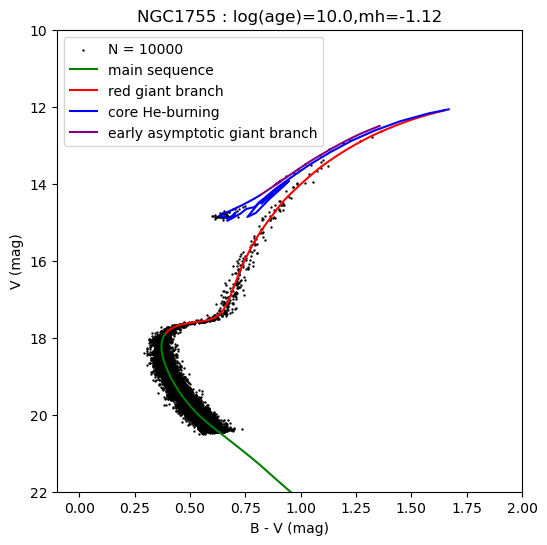

In [53]:
index = set(range(len(cat))) - set(np.where(cat['secmass']>0)[0])
# MS = np.where((isoc['label']==1))[0] # main sequence
# SGB = np.where((isoc['label']==2))[0] # subgiant branch, or Hertzsprung gap for more intermediate+massive stars
# RGB = np.where((isoc['label']==3))[0] # red giant branch, or the quick stage of red giant for intermediate+massive stars
# CHEB = np.where((isoc['label']==4))[0] # core He-burning for low mass stars, or the very initial stage of CHeB for intermediate+massive stars
# CHEB_b = np.where((isoc['label']==5))[0] # the blueward part of the Cepheid loop of intermediate+massive stars
# CHEB_r = np.where((isoc['label']==6))[0] # the redward part of the Cepheid loop of intermediate+massive stars
# EAGB = np.where((isoc['label']==7))[0] # the early asymptotic giant branch, or a quick stage of red giant for massive stars

# -1=PMS, 0=MS, 2=RGB, 3=CHeB, 4=EAGB, 5=TPAGB, 6=postAGB, 9=WR
PMS = np.where((isoc['phase']==-1))[0] # main sequence
MS = np.where((isoc['phase']==0))[0] # subgiant branch, or Hertzsprung gap for more intermediate+massive stars
RGB = np.where((isoc['phase']==2))[0] # red giant branch, or the quick stage of red giant for intermediate+massive stars
CHEB = np.where((isoc['phase']==3))[0] # core He-burning for low mass stars, or the very initial stage of CHeB for intermediate+massive stars
EAGB = np.where((isoc['phase']==4))[0] # the blueward part of the Cepheid loop of intermediate+massive stars
TPAGB = np.where((isoc['phase']==5))[0] # the redward part of the Cepheid loop of intermediate+massive stars
postAGB = np.where((isoc['phase']==6))[0]

name='NGC1755'
fig,ax =plt.subplots(figsize=(6,6))
ax.scatter(cat['%s_obs'%(b)][index]-cat['%s_obs'%(v)][index], cat['%s_obs'%(v)][index],s=0.5,c='k',alpha=1,label='N = %d'%len(cat))
ax.plot(isoc[b][MS]-isoc[v][MS], isoc[v][MS]+dist_mod, color='green', label='main sequence')
#ax.plot(isoc[b][SGB]-isoc[v][SGB], isoc[v][SGB]+dist_mod, color='orange', label='subgiant branch')
ax.plot(isoc[b][RGB]-isoc[v][RGB], isoc[v][RGB]+dist_mod, color='red', label='red giant branch')
ax.plot(isoc[b][CHEB]-isoc[v][CHEB], isoc[v][CHEB]+dist_mod, color='blue', label='core He-burning')
ax.plot(isoc[b][EAGB]-isoc[v][EAGB], isoc[v][EAGB]+dist_mod, color='purple', label='early asymptotic giant branch')
#ax.plot(isoc[b][TPAGB]-isoc[v][TPAGB], isoc[v][TPAGB]+dist_mod, color='pink', label='TPAGB')
#ax.plot(isoc[b][postAGB]-isoc[v][postAGB], isoc[v][postAGB]+dist_mod, color='orange', label='postAGB')
ax.invert_yaxis()
ax.legend()
ax.set_title('%s : log(age)=%s,mh=%s'%(name,str(logAge),str(MH)))
ax.set_xlabel("B - V (mag)")
ax.set_ylabel("V (mag)")
ax.set_ylim(22,10)
ax.set_xlim(-0.1,2)

In [60]:
f_mass_band = spl.interp1d(isoc['initial_mass'], isoc['Bessell_B'])

EEP,log10_isochrone_age_yr,initial_mass,star_mass,log_Teff,log_g,log_L,[Fe/H]_init,[Fe/H],Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,2MASS_J,2MASS_H,2MASS_Ks,Kepler_Kp,Kepler_D51,Hipparcos_Hp,Tycho_B,Tycho_V,Gaia_G_DR2Rev,Gaia_BP_DR2Rev,Gaia_RP_DR2Rev,Gaia_G_MAW,Gaia_BP_MAWb,Gaia_BP_MAWf,Gaia_RP_MAW,TESS,Gaia_G_EDR3,Gaia_BP_EDR3,Gaia_RP_EDR3,phase,_lgmass,_mhini,_lgage,_eep
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
244,10.0,0.1,0.09999914480493008,3.5302065787014376,5.3320995243170675,-2.818485010397106,-1.12,-1.078062,17.038164,15.197521,13.46558,12.33251,11.245905,10.039533,9.28267,9.055629,12.481447,14.490652,13.437222,15.743472,13.680432,12.523476,13.725343,11.485902,12.500475,13.671252,13.718161,11.465718,11.438389,12.520192,13.698544,11.467186,0.0,-1.0,-1.12,10.0,244
245,10.0,0.1017056007457137,0.10170471709299955,3.5314266351269,5.327006782948439,-2.802505279861405,-1.12,-1.078005,16.946638,15.127972,13.404666,12.278327,11.201674,10.00187,9.247764,9.021297,12.429417,14.422522,13.379655,15.668888,13.61859,12.472401,13.665051,11.439797,12.449287,13.611354,13.658319,11.419648,11.392925,12.469028,13.638247,11.421254,0.0,-0.9926551305975744,-1.12,10.0,245
246,10.0,0.10518088970714301,0.10517994403487099,3.533945722911496,5.316551982301998,-2.7697349050161852,-1.12,-1.077872,16.76144,14.986715,13.277212,12.169381,11.111302,9.924789,9.176039,8.95101,12.323461,14.284002,13.260131,15.51745,13.489523,12.368338,13.539572,11.345475,12.345002,13.486655,13.533953,11.325411,11.299929,12.364788,13.512634,11.32732,0.0,-0.9780631598843366,-1.12,10.0,246
247,10.0,0.1085384606339338,0.10853745117937794,3.5363799096348254,5.306443455851868,-2.7380649922394507,-1.12,-1.077749,16.586731,14.852525,13.157743,12.065465,11.024319,9.850518,9.106915,8.883221,12.223525,14.152258,13.148323,15.373817,13.368444,12.269017,13.421106,11.254398,12.245625,13.36935,13.416619,11.234446,11.210497,12.265437,13.39428,11.236715,0.0,-0.964416342171772,-1.12,10.0,247
248,10.0,0.11178280794360301,0.1117817330748217,3.538732380066476,5.296668272590056,-2.7074540427430946,-1.12,-1.077626,16.416145,14.721275,13.045934,11.966322,10.940825,9.779007,9.040365,8.817926,12.128135,14.024773,13.041785,15.237612,13.254879,12.175253,13.310144,11.167303,12.151654,13.259021,13.306351,11.147348,11.124308,12.171502,13.283321,11.149779,0.0,-0.9516249852631825,-1.12,10.0,248
249,10.0,0.11537917411851148,0.115378022464453,3.541339456641304,5.285823411028664,-2.6735152639219972,-1.12,-1.077483,16.232206,14.579799,12.924127,11.857871,10.849121,9.699923,8.966997,8.745897,12.023764,13.885521,12.925413,15.086496,13.131153,12.072712,13.189162,11.072788,12.048864,13.138688,13.186066,11.052818,11.030531,12.068748,13.162346,11.055412,0.0,-0.9378725740367156,-1.12,10.0,249
250,10.0,0.11887942150750336,0.11887819023151108,3.5438774414784735,5.2752549065411625,-2.6404677257341826,-1.12,-1.077326,16.059845,14.446049,12.807531,11.753651,10.761417,9.623378,8.896084,8.676359,11.923535,13.753337,12.813751,14.943358,13.01272,11.974338,13.073274,10.98205,11.950221,13.023383,13.070788,10.962155,10.94085,11.970132,13.046465,10.965002,0.0,-0.9248933169474838,-1.12,10.0,250
251,10.0,0.12231454260928258,0.12231322795146941,3.546369365453523,5.264864780971772,-2.608012177799168,-1.12,-1.077188,15.895866,14.317738,12.694625,11.652338,10.675735,9.548519,8.826813,8.608422,11.826099,13.626013,12.705357,14.806291,12.898026,11.878747,12.960963,10.893472,11.85435,12.911601,12.959018,10.87361,10.853174,11.874285,12.934163,10.876655,0.0,-0.9125219043742507,-1.12,10.0,251
252,10.0,0.1257133095609798,0.12571190733831938,3.5488345551225606,5.254570433857843,-2.575887384234988,-1.12,-1.077046,15.736641,14.192372,12.583952,11.552676,10.591208,9.474513,8.758369,8.5

In [37]:
b = 'Bessell_B'
v = 'Bessell_V'
isoc[v][MS]+dist_mod

NameError: name 'dist_mod' is not defined

(array([131., 101., 116., 136., 105., 130., 105., 107., 102., 124., 120.,
        130., 119., 124., 116., 109., 138., 115., 106., 110., 111., 124.,
         95., 112., 121., 112., 106., 116., 103., 100., 103., 102.,  86.,
        113., 109.,  96.,  77.,  89.,  96.,  94.,  98., 105., 104., 103.,
         96.,  95., 106., 104., 101., 102.,  96.,  94.,  78.,  84.,  91.,
         89., 102.,  93.,  77.,  95.,  88.,  91.,  93.,  93.,  75.,  92.,
         82.,  66., 100.,  73.,  90.,  63.,  73.,  77.,  83.,  75.,  85.,
         72.,  86.,  97.,  71.,  53.,  73.,  62.,  73.,  62.,  53.,  50.,
         45.,  64.,  59.,  50.,  52.,  53.,  46.,  55.,  45.,  38.,  46.,
         46.]),
 array([-1.02837663, -1.01882338, -1.00927012, -0.99971687, -0.99016361,
        -0.98061036, -0.97105711, -0.96150385, -0.9519506 , -0.94239735,
        -0.93284409, -0.92329084, -0.91373758, -0.90418433, -0.89463108,
        -0.88507782, -0.87552457, -0.86597132, -0.85641806, -0.84686481,
        -0.83731155, -0.82

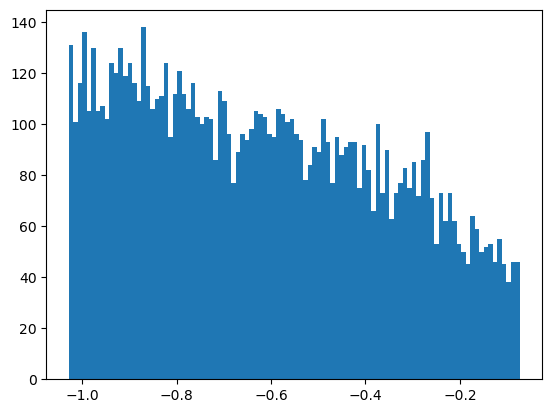

In [87]:
plt.hist(np.log10(cat['primass']),bins=100)

In [21]:
temiso.columns

Index(['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe',
       'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'period2',
       'period3', 'period4', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn',
       'Xo', 'Cexcess', 'Z', 'mbolmag', 'F435Wmag', 'F475Wmag', 'F502Nmag',
       'F550Mmag', 'F555Wmag', 'F606Wmag', 'F625Wmag', 'F658Nmag', 'F660Nmag',
       'F775Wmag', 'F814Wmag', 'F850LPmag'],
      dtype='object')

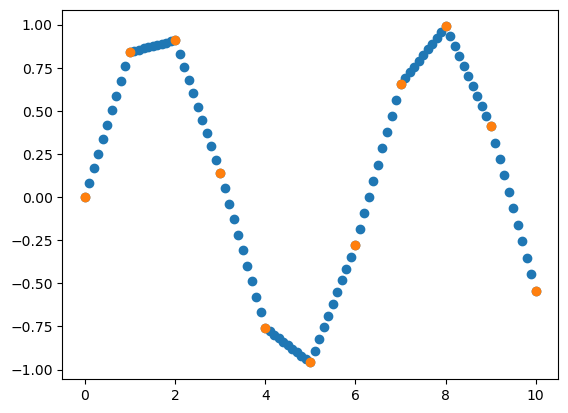

In [59]:
from scipy import interpolate
import numpy as np

x = np.linspace(0,10,11)
y = np.sin(x)
f = interpolate.interp1d(x,y)

xnew = np.linspace(0,10,101)
df = pd.DataFrame(np.zeros(101),columns=['xnew'])
df['xnew'] = xnew

ynew = f(df['xnew'])
plt.scatter(xnew,ynew)
plt.scatter(x,y)


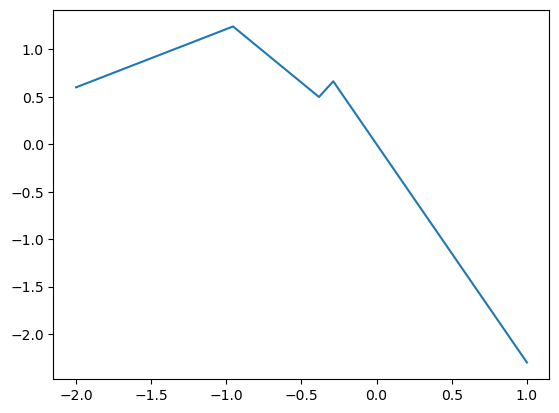

In [77]:
x = np.linspace(0.01,10,100)
def imf(x):
    if x<0.08:
        alpha=0.3
    elif 0.08<x<0.5:
        alpha=1.3
    elif 0.5<x:
        alpha=2.3
    return x**-alpha
#imf = lambda x: x ** -1.3 if x < 0.5 else x ** -2.3
plt.plot(np.log10(x),np.log10([imf(_) for _ in x]))

/tmp/ipykernel_3108576/104844189.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(x),np.log10([imf(_) for _ in x]))


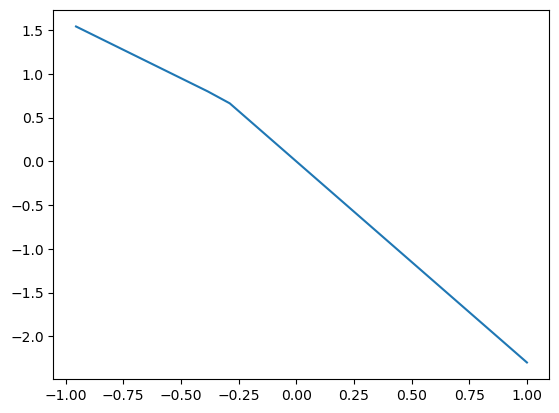

In [80]:
x = np.linspace(0.01,10,100)
def imf(m_x):
    if m_x < 0.08 : 
        return 0
    elif m_x < 0.5 : 
        return 2*m_x**(-1.3)
    elif m_x < 150:
        return m_x**(-2.3)
    else :
        return 0
#imf = lambda x: x ** -1.3 if x < 0.5 else x ** -2.3
plt.plot(np.log10(x),np.log10([imf(_) for _ in x]))